In [1]:
import os, pickle
import numpy as np

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import evals.teaching_evals as evals
import pickle
import utils
import figs.plot_data as plot
import algorithms.teaching_algs as algs
y_train = np.array([0]*80+[1]*80)
y_valid = np.array([0]*20+[1]*20)
import seaborn as sns

## load data

In [2]:
dwac_train = pickle.load(open("embeds/bm/dwac_train_emb10.merged10.pkl","rb"))
dwac_valid = pickle.load(open("embeds/bm/dwac_valid_emb10.merged10.pkl","rb"))
resn_train = pickle.load(open("embeds/bm/resn_train_emb10.pkl","rb"))
resn_valid = pickle.load(open("embeds/bm/resn_valid_emb10.pkl","rb"))
TN_train = pickle.load(open("embeds/bm/human/TN_train_emb10.pkl","rb"))
TN_valid = pickle.load(open("embeds/bm/human/TN_valid_emb10.pkl","rb"))
MTL_train = pickle.load(open("embeds/bm/human/MTL.BCETN_train_emb10.pkl","rb"))
MTL_valid = pickle.load(open("embeds/bm/human/MTL.BCETN_valid_emb10.pkl","rb"))

In [3]:
embeds = {"dwac": (dwac_train,dwac_valid), 
"resn": (resn_train,resn_valid), 
"TN_human":(TN_train,TN_valid),
"MTL_human": (MTL_train,MTL_valid)}
legend = ['full', 'random', 'random_ci'] + list(embeds.keys())

## knn using model embeds

In [4]:
def get_model_knn_scores(data, m_range, selection_alg, k=1, args=None):
    if selection_alg == "protogreedy":
        selection_alg = algs.protogreedy
    elif selection_alg == "prototriplet":
        selection_alg = algs.prototriplet

    x_train, y_train, x_valid, y_valid = data
    prototype_knn_scores = []
    for m in m_range:
        prototype_idx = selection_alg(x_train, m, args)
        knn_score = evals.get_knn_score(x_train[prototype_idx], y_train[prototype_idx], x_valid, y_valid, k=k)
        prototype_knn_scores.append(knn_score)

    print(prototype_knn_scores)
    return prototype_knn_scores

In [5]:
m_range = np.arange(2,21)
selection_alg = "protogreedy"

[0.85, 0.85, 0.775, 0.775, 0.8, 0.8, 0.775, 0.775, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.8, 0.8, 0.8, 0.8]


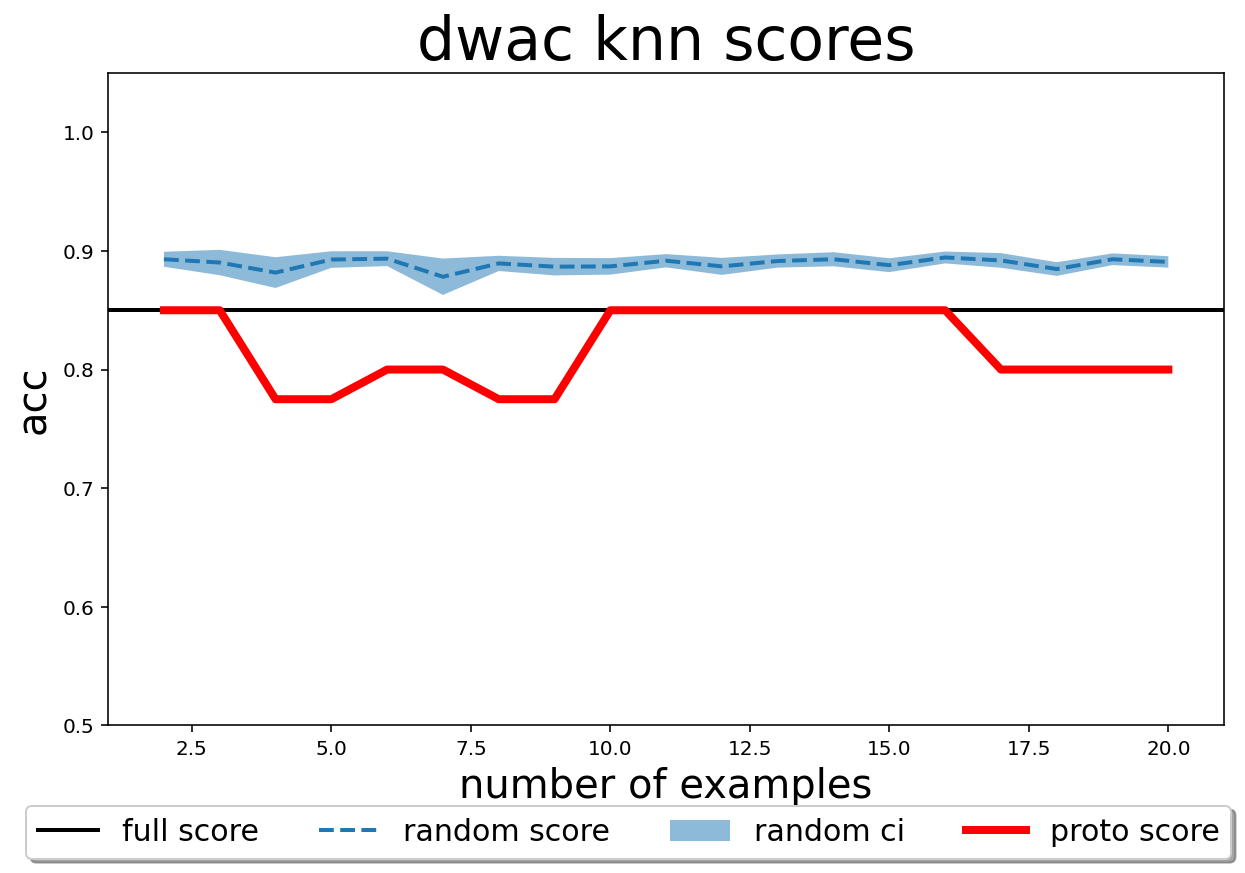

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


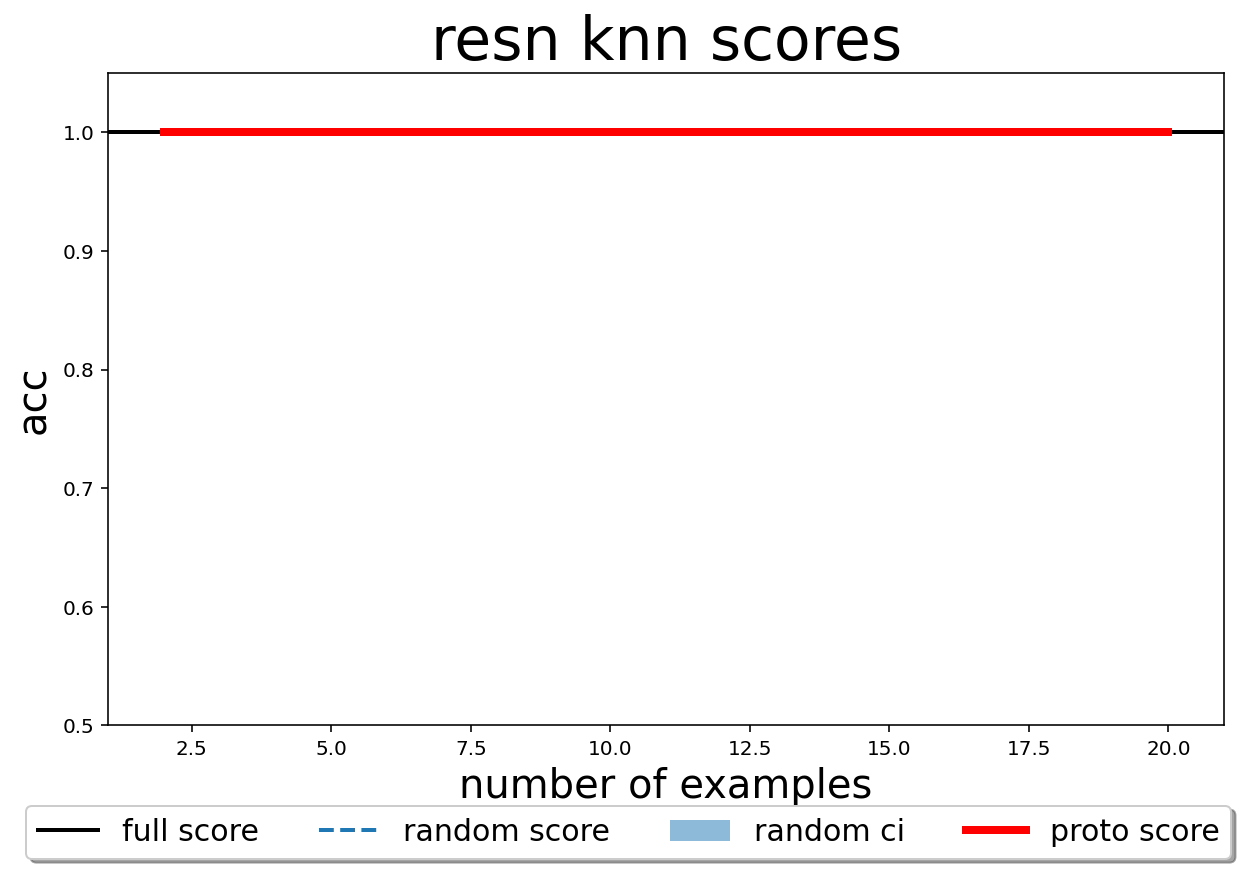

[0.7, 0.7, 0.9, 0.9, 0.9, 0.875, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.825, 0.825, 0.825, 0.825, 0.825]


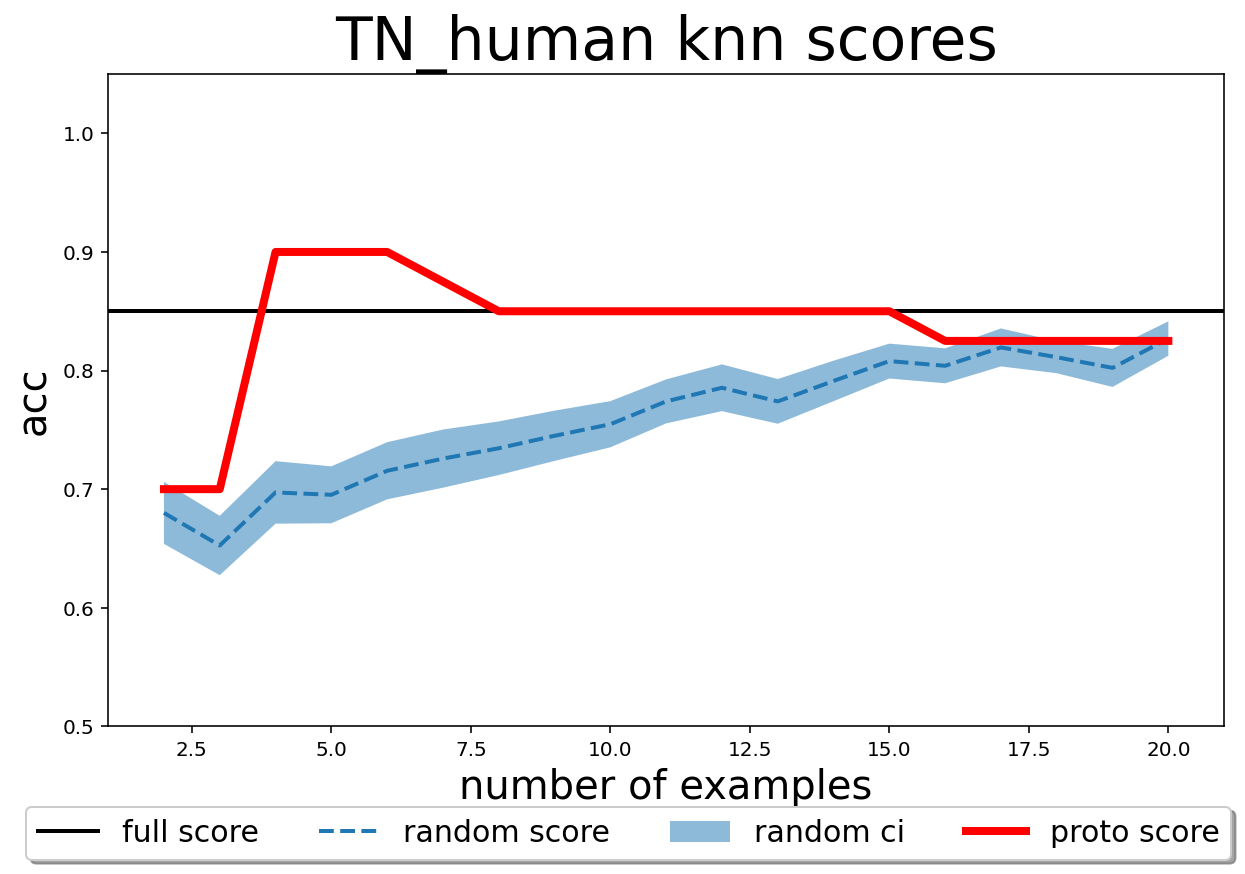

[0.825, 0.825, 0.925, 0.9, 0.9, 0.9, 0.9, 0.9, 0.925, 0.925, 0.925, 0.925, 0.9, 0.9, 0.9, 0.9, 0.9, 0.925, 0.925]


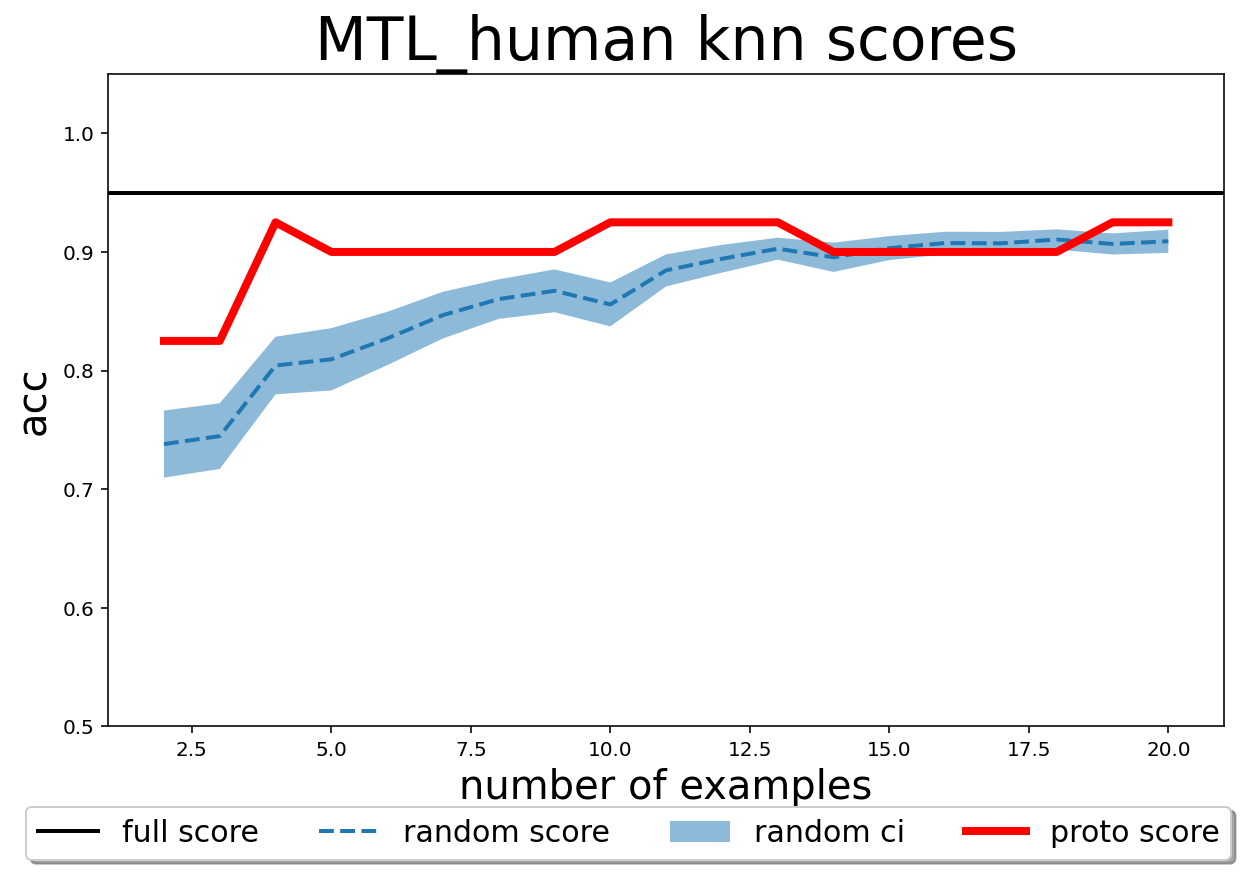

In [6]:
for model, (x_train,x_valid) in embeds.items():
    scores = {}
    data = x_train, y_train, x_valid, y_valid
    scores["full_score"],  (scores["random_scores"], scores["random_ci"]) = evals.get_full_random(data, m_range)
    scores["prototype_knn_scores"] = get_model_knn_scores(data, m_range, selection_alg)
    title = f"{model} knn scores"
    plot.vis_knn_scores(m_range, scores, title=title, save=True, save_dir=f"figs/model_knn/{title}.pdf")

## knn using human triplets

In [7]:
train_embs = np.array(pickle.load(open("embeds/bm/human/TN_train_emb10.pkl","rb")))
valid_embs = np.array(pickle.load(open("embeds/bm/human/TN_valid_emb10.pkl","rb")))
def get_htriplet_knn_scores(X, m_range, selection_alg, k=1, args=None):
    if selection_alg == "protogreedy":
        selection_alg = algs.protogreedy
    elif selection_alg == "prototriplet":
        selection_alg = algs.prototriplet

    prototype_knn_scores = []
    for m in m_range:
        prototype_idx = selection_alg(X, m, args)
        knn_score = evals.get_knn_score(train_embs[prototype_idx], y_train[prototype_idx], valid_embs, y_valid, k=k)
        prototype_knn_scores.append(knn_score)

    print(prototype_knn_scores)
    return prototype_knn_scores

In [8]:
m_range = np.arange(4,21)
data = (train_embs, y_train, valid_embs, y_valid)
full_score,  random_scores = evals.get_full_random(data, m_range)

In [9]:
protog_scores = {"full_score":full_score, "random_scores":random_scores}
selection_alg = "protogreedy"
for model, embed in embeds.items():
    protog_scores[model] = get_htriplet_knn_scores(embed[0], m_range, selection_alg=selection_alg)

[0.5, 0.5, 0.7, 0.7, 0.8, 0.8, 0.8, 0.8, 0.825, 0.825, 0.75, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]
[0.775, 0.625, 0.675, 0.675, 0.675, 0.75, 0.75, 0.75, 0.75, 0.725, 0.75, 0.75, 0.775, 0.775, 0.775, 0.75, 0.75]
[0.9, 0.9, 0.9, 0.875, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.825, 0.825, 0.825, 0.825, 0.825]
[0.9, 0.875, 0.875, 0.875, 0.875, 0.9, 0.9, 0.9, 0.875, 0.875, 0.825, 0.825, 0.85, 0.85, 0.85, 0.85, 0.85]


In [10]:
protot10_scores = {"full_score":full_score, "random_scores":random_scores}
selection_alg = "prototriplet"
args = {"topk":10}
for model, embed in embeds.items():
    print(model)
    protot10_scores[model] = get_htriplet_knn_scores(embed[0], m_range, selection_alg, args=args)

dwac
[0.75, 0.75, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.825, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]
resn
[0.775, 0.775, 0.775, 0.775, 0.775, 0.775, 0.775, 0.775, 0.825, 0.825, 0.825, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
TN_human
[0.525, 0.55, 0.55, 0.575, 0.575, 0.575, 0.575, 0.6, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.725, 0.725, 0.725]
MTL_human
[0.525, 0.55, 0.55, 0.575, 0.575, 0.575, 0.575, 0.6, 0.675, 0.675, 0.675, 0.675, 0.675, 0.675, 0.725, 0.725, 0.725]


In [11]:
protot100_scores = {"full_score":full_score, "random_scores":random_scores}
selection_alg = "prototriplet"
args = {"topk":100}
for model, embed in embeds.items():
    print(model)
    protot100_scores[model] = get_htriplet_knn_scores(embed[0], m_range, selection_alg, args=args)

dwac
[0.75, 0.825, 0.825, 0.825, 0.825, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85]
resn
[0.825, 0.75, 0.75, 0.75, 0.75, 0.875, 0.875, 0.875, 0.9, 0.9, 0.9, 0.9, 0.9, 0.85, 0.85, 0.85, 0.8]
TN_human
[0.525, 0.55, 0.55, 0.575, 0.575, 0.575, 0.65, 0.65, 0.65, 0.625, 0.625, 0.625, 0.625, 0.65, 0.65, 0.65, 0.625]
MTL_human
[0.525, 0.55, 0.55, 0.575, 0.575, 0.575, 0.65, 0.65, 0.65, 0.625, 0.625, 0.625, 0.625, 0.65, 0.65, 0.65, 0.625]


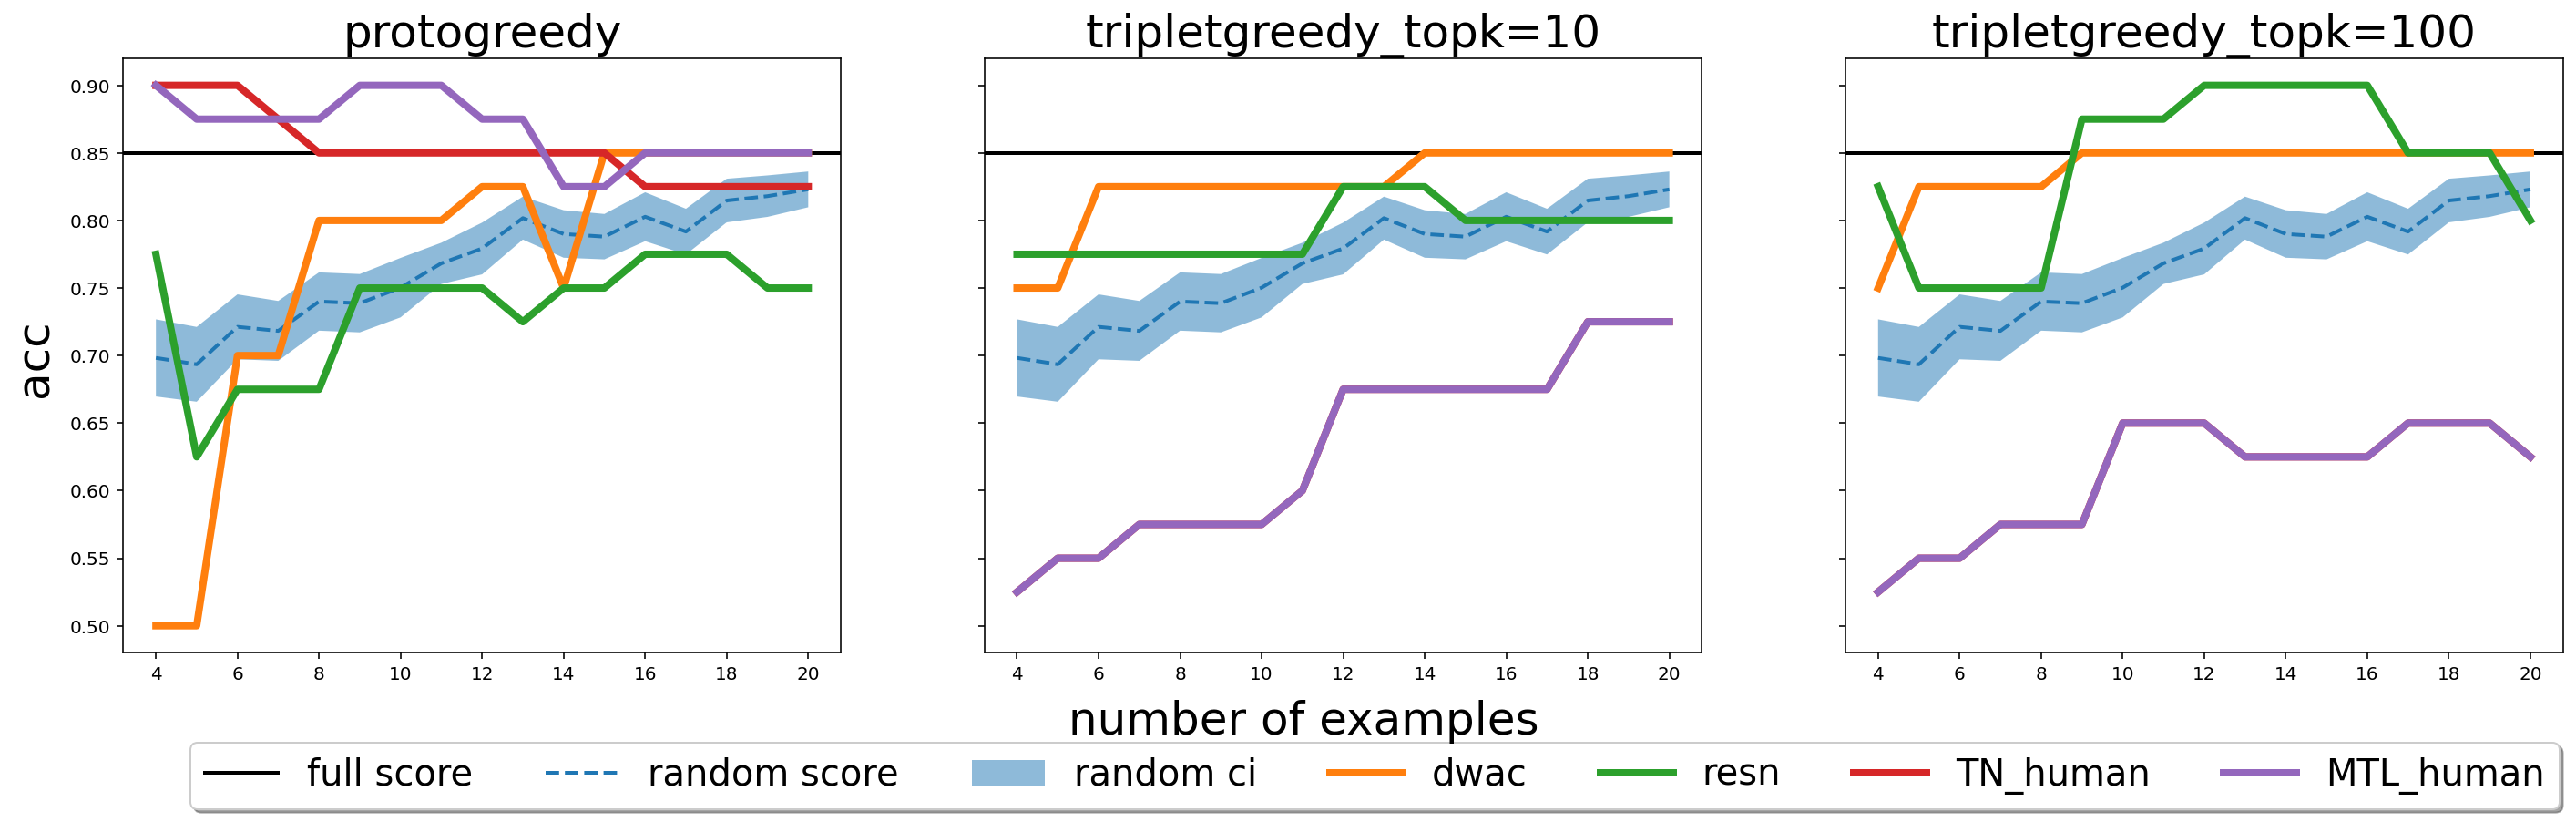

In [60]:
plot.vis_knn_scores_multiplot(m_range, [protog_scores, protot10_scores, protot100_scores], 
subtitles=["protogreedy","tripletgreedy_topk=10","tripletgreedy_topk=100"],
save=True, save_dir="figs/KNN_TN.pdf")

TSNEing


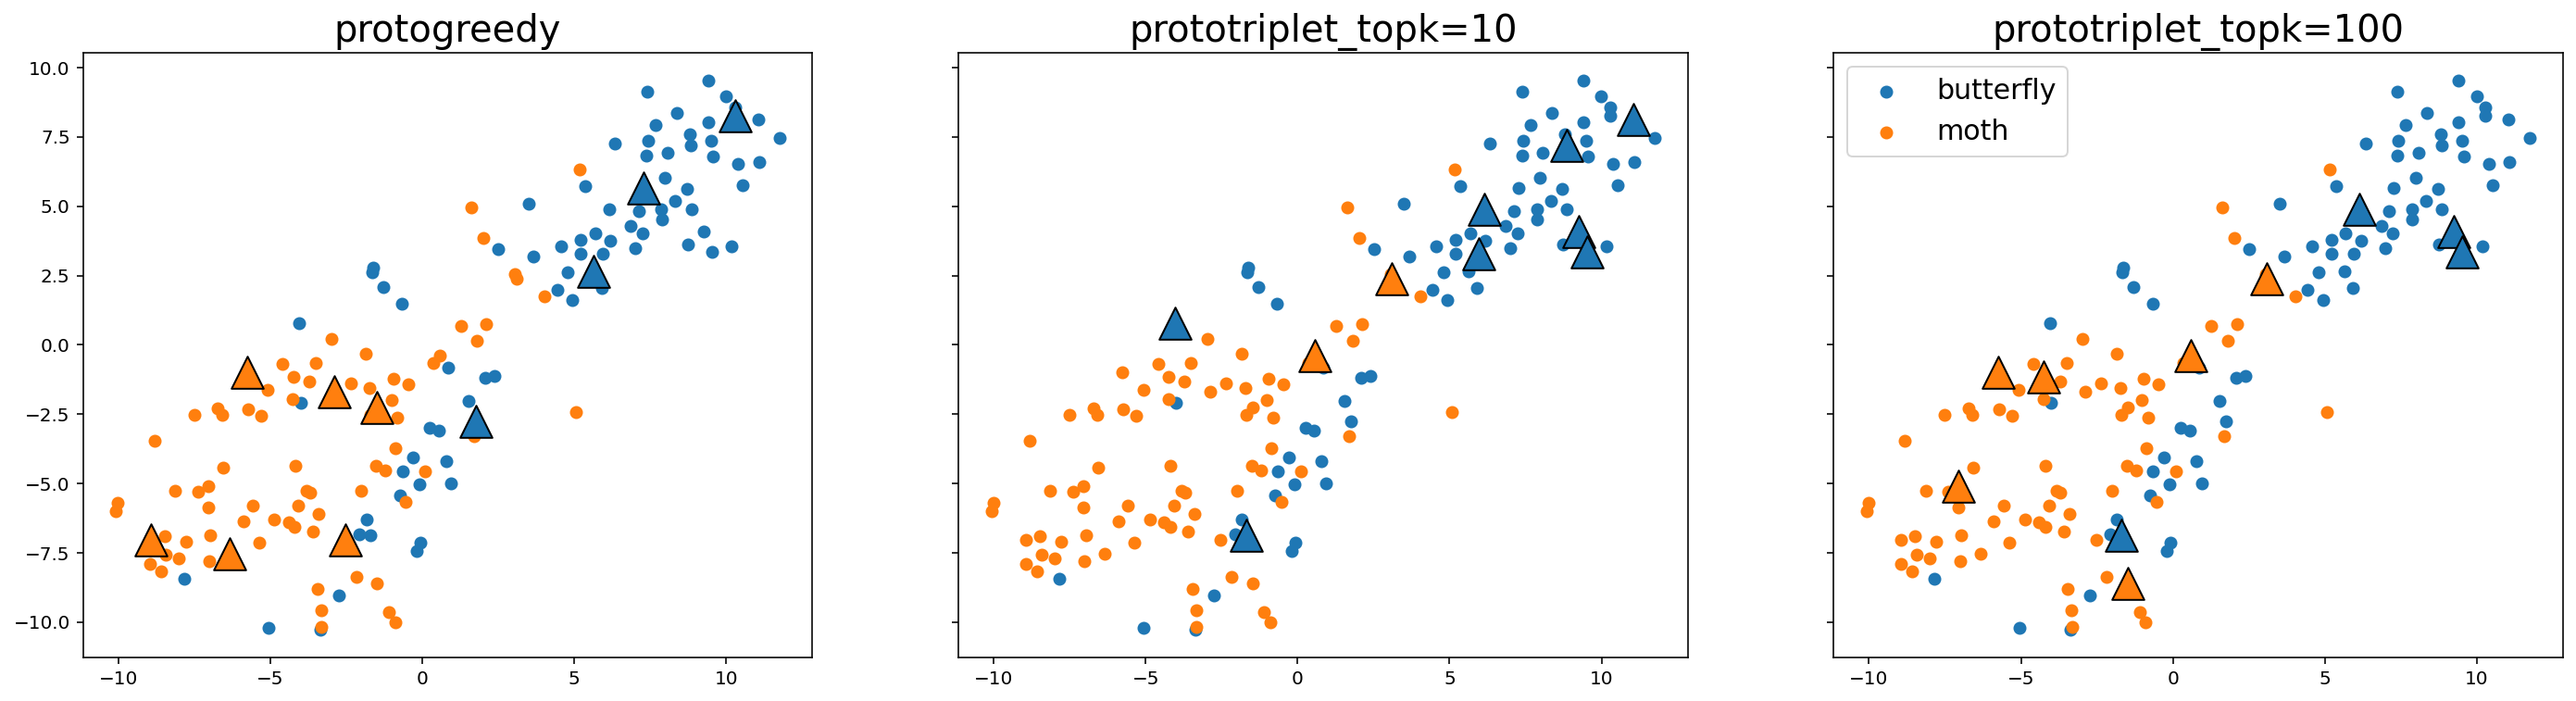

In [5]:
x = plot.tsne2(TN_train)
prototriplet10 = algs.prototriplet(TN_train, 10, {"topk":10})
prototriplet100 = algs.prototriplet(TN_train, 10, {"topk":100})
protogreedy = algs.protogreedy(TN_train, 10)
plot.vis_data_multiplot([(x,y_train),(x,y_train),(x,y_train)], ["butterfly","moth"], 
subtitles=["protogreedy","prototriplet_topk=10","prototriplet_topk=100"], prototype_idx=[protogreedy,prototriplet10,prototriplet100], 
save=True, save_dir="figs/bm_m=10.pdf")